In [3]:
import pandas as pd
from sqlalchemy import create_engine
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
engine = create_engine('sqlite:///books.db')

books_review = pd.read_sql('SELECT * FROM books_review', engine)
books_data = pd.read_sql('SELECT * FROM books_data LIMIT 10000', engine)

books_data['authors'] = books_data['authors'].apply(lambda x: eval(x) if isinstance(x, str) else None)

books_data['categories'] = books_data['categories'].apply(lambda x: eval(x) if isinstance(x, str) else None)

In [5]:
books_data.keys()

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount',
       'review_mean', 'review_ids'],
      dtype='object')

In [6]:
# Calculando a média das notas dos reviews
## Primeiro, vamos criar um conjunto de autores
autores = set()
for authors in books_data['authors']:
    if not authors:
        continue
    for single_author in authors:
        autores.add(single_author)

clean_books_data = books_data[books_data['authors'].apply(lambda x: isinstance(x, list))]
clean_books_data = clean_books_data[clean_books_data['review_mean'].apply(bool)]
## Vamos também transformar a lista de autores em sets, para aproveitar as funcionalidades de hashing desse tipo
clean_books_data['authors'] = clean_books_data['authors'].apply(lambda x: set(x) if isinstance(x, list) else None)

In [7]:
notas_autores = defaultdict(list) # as notas dos autores serão inseridas aqui

for autor in tqdm(autores):
    notas_autores[autor].extend(list(clean_books_data[clean_books_data['authors'].apply(lambda x: autor in x)]['review_mean']))

  0%|          | 0/10880 [00:00<?, ?it/s]

In [8]:
# Vamos criar um dataframe para representar todos os autores, suas notas, médias e quantidade de notas
df_notas_autores = pd.DataFrame({
    "authors": notas_autores.keys(),
    "reviews_avg_per_book": notas_autores.values()
})

In [9]:
df_notas_autores['reviews_avg'] = df_notas_autores['reviews_avg_per_book'].apply(lambda x: sum(x)/len(x) if x else None)

In [10]:
df_notas_autores['n_reviews'] = df_notas_autores['reviews_avg_per_book'].apply(len)

In [11]:
# Filtrando autores com base em critérios de sucesso

# Definir uma série de regras para "limpar" o dataset.
# 1. Autores com notas baixas (abaixo de um trashold _t_score_) são eliminados
# 2. Autores com poucos reviews são eliminados (abaixo de um trashold _t_nreviews_)
# 3. Autores com reviews acima do _t_nreviews_ e notas acima do _t_score_ são considerados

t_score = 3
t_nreviews = 5

df_notas_autores_clean = df_notas_autores[df_notas_autores['n_reviews'] >= t_nreviews]


In [12]:
df_notas_autores_clean = df_notas_autores_clean[df_notas_autores_clean['reviews_avg'] >= t_score]

/tmp/ipykernel_742914/2464255820.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='reviews_avg', y='authors', data=df_top_authors, palette='viridis')


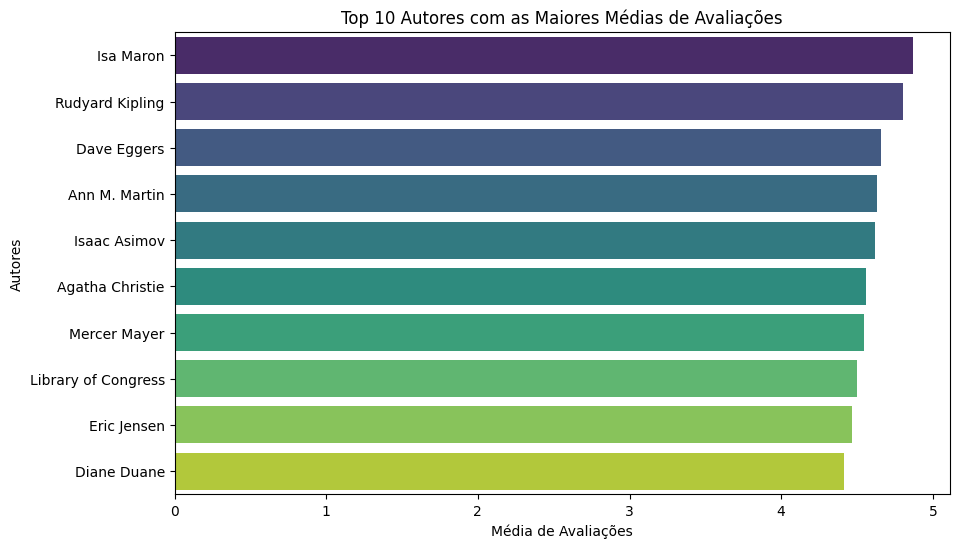

In [13]:
# Ordenar o DataFrame pelos autores com maior média de avaliações
df_top_authors = df_notas_autores_clean.sort_values(by='reviews_avg', ascending=False).head(10)

# Criar o gráfico de barras horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x='reviews_avg', y='authors', data=df_top_authors, palette='viridis')
plt.title('Top 10 Autores com as Maiores Médias de Avaliações')
plt.xlabel('Média de Avaliações')
plt.ylabel('Autores')
plt.show()

In [14]:
clean_books_rewiews = books_review.dropna()

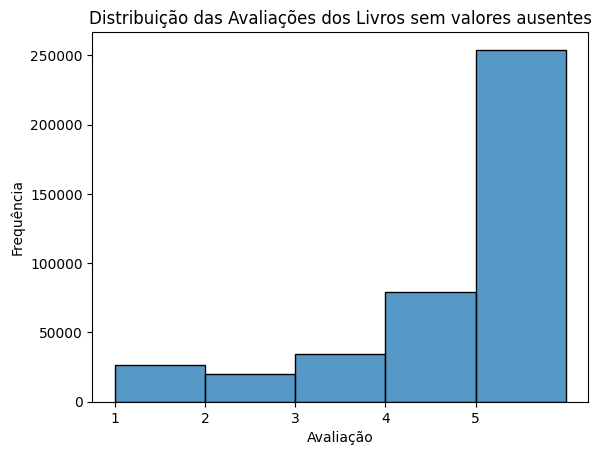

In [15]:
# Análise de distribuição de score
sns.histplot(clean_books_rewiews['score'], bins=range(1, 7), kde=False) # add a curva KDE para observar melhor

plt.title('Distribuição das Avaliações dos Livros sem valores ausentes')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.xticks(range(1, 6))  # Ajusta as marcações do eixo x para mostrar apenas 1, 2, 3, 4, 5
plt.show()

/tmp/ipykernel_742914/3310293273.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_data['average_rating'].fillna(0, inplace=True)
/tmp/ipykernel_742914/3310293273.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

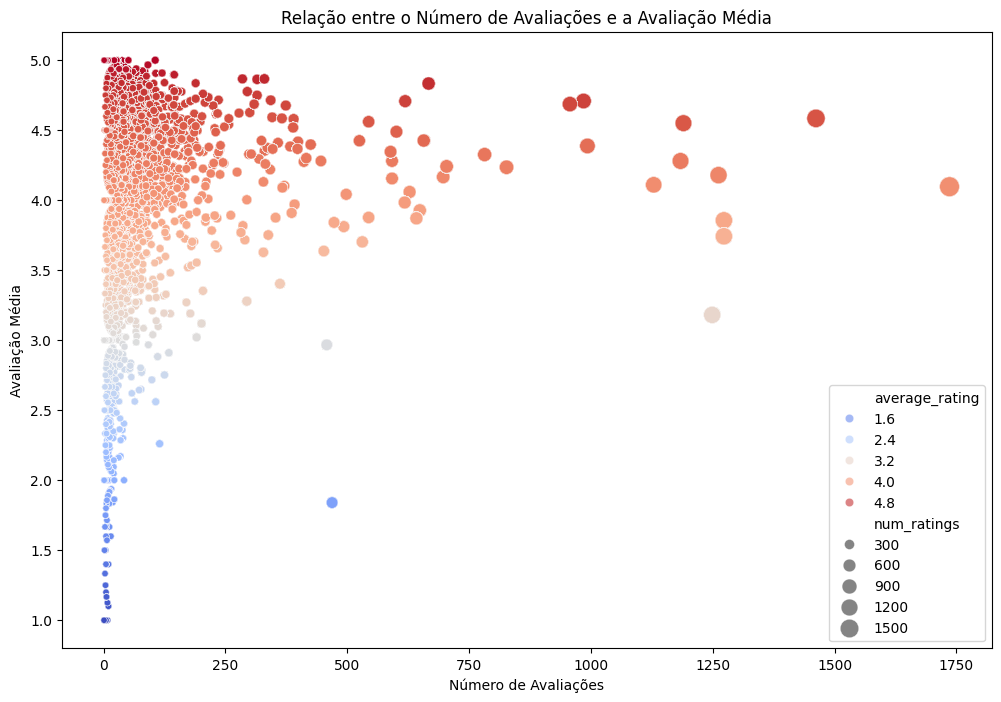

In [16]:
# Calculando a média e o número de avaliações por título no dataframe 'book_ratings'
ratings_summary = clean_books_rewiews.groupby('Title')['score'].agg(['mean', 'count']).reset_index() # Cria um resumo das avaliações (ratings_summary) agrupando por título de livro para calcular a média (mean) e o número total de avaliações (count)
ratings_summary.columns = ['Title', 'average_rating', 'num_ratings']

# Unindo os dados de resumo com o 'books_data' com base no título
books_data = pd.merge(clean_books_rewiews, ratings_summary, on='Title', how='left')
books_data['average_rating'].fillna(0, inplace=True)
books_data['num_ratings'].fillna(0, inplace=True)

# Plotando o gráfico de dispersão
plt.figure(figsize=(12, 8))
sns.scatterplot(data=books_data, x='num_ratings', y='average_rating', hue='average_rating', 
                palette='coolwarm', size='num_ratings', sizes=(20, 200), alpha=0.6)

plt.title('Relação entre o Número de Avaliações e a Avaliação Média')
plt.xlabel('Número de Avaliações')
plt.ylabel('Avaliação Média')
plt.show()

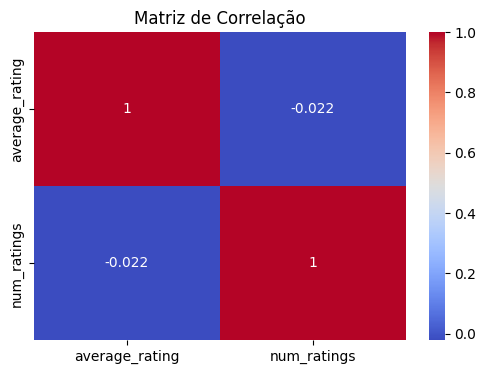

In [17]:
clean_books_data = books_data.dropna(subset=['average_rating', 'num_ratings'])
required_columns = ['average_rating', 'num_ratings']
missing_columns = [col for col in required_columns if col not in clean_books_data.columns]

if missing_columns:
    print(f"Colunas ausentes: {missing_columns}. Verifique o DataFrame limpo.")
else:
    correlation_matrix = clean_books_data[['average_rating', 'num_ratings']].corr()

    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Matriz de Correlação')
    plt.show()

In [18]:
# Análise Temporal - Distribuição de Avaliações ao Longo do Tempo
plt.figure(figsize=(12, 6))
clean_books_data['publishedDate'] = pd.to_datetime(clean_books_data['publishedDate'], errors='coerce')
clean_books_data['publishedYear'] = clean_books_data['publishedDate'].dt.year
sns.histplot(clean_books_data['publishedYear'].dropna(), bins=30, kde=True)
plt.title('Distribuição de Publicações ao Longo do Tempo')
plt.xlabel('Ano de Publicação')
plt.ylabel('Frequência')
plt.show()

KeyError: 'publishedDate'

<Figure size 1200x600 with 0 Axes>